In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dwave_networkx as dnx

In [1]:
import networkx as nx
from tqdm import trange
from fairness_goodness_computation import *
import csv 

Data = open('soc-sign-bitcoinotc.csv', "r")
next(Data, None)  # skip the first line in the input file
Graphtype = nx.DiGraph()

G = nx.parse_edgelist(Data, delimiter=',', create_using=Graphtype, nodetype=int, data=(('Weight', int),('Timestamp', int)))

# Setting weights -1 to 1
weights = nx.get_edge_attributes(G,"Weight")
for key, val in weights.items():
    weights[key] = val/10
nx.set_edge_attributes(G, weights, "Weight")

In [2]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 5881
Number of edges: 35592
Average in degree:   6.0520
Average out degree:   6.0520


In [467]:
S = nx.Graph()
S.add_edge(1, 2, Weight=1)
S.add_edge(2, 3, Weight=1)
S.add_edge(3, 4, Weight=1)
S.add_edge(2, 4, Weight=1)
S.add_edge(1, 5, Weight=1)
S.add_edge(6, 7, Weight=1)
S.add_edge(7, 8, Weight=1)
S.add_edge(7, 9, Weight=1)
S.add_edge(6, 10, Weight=1)
S.add_edge(8, 11, Weight=1)
S.add_edge(10, 11, Weight=1)

S.add_edge(1, 6, Weight=-1)
S.add_edge(4, 9, Weight=-1)
S.add_edge(2, 11, Weight=-1)
S.add_edge(5, 5, Weight=-1)
S.add_edge(3, 10, Weight=-1)
S.add_edge(4, 7, Weight=-1)


In [468]:
H = S

In [167]:
[len(c) for c in sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)]

[5875, 2, 2, 2]

In [433]:
nodes = []
WW = nx.get_edge_attributes(G,"Weight")
count = 0
for i in (G.edges):
    if(WW[i] < 0):
        nodes.append(i[0])
        nodes.append(i[1])
        count+=2
    if(count == 40):
        break    

In [434]:
H = G.to_undirected().subgraph(nodes)
nx.info(H)

'Name: \nType: Graph\nNumber of nodes: 20\nNumber of edges: 43\nAverage degree:   4.3000'

In [469]:
np.unique((np.array(list(nx.get_edge_attributes(H,"Weight").values()) ) > 0).astype(int), return_counts = 1)

(array([0, 1]), array([ 6, 11], dtype=int64))

In [470]:
A = nx.adjacency_matrix(H, weight = "Weight")

In [471]:
print('Adjacency matrix:')
A.todense()

Adjacency matrix:


matrix([[ 0,  1,  0,  0,  1, -1,  0,  0,  0,  0,  0],
        [ 1,  0,  1,  1,  0,  0,  0,  0,  0,  0, -1],
        [ 0,  1,  0,  1,  0,  0,  0,  0,  0, -1,  0],
        [ 0,  1,  1,  0,  0,  0, -1,  0, -1,  0,  0],
        [ 1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0],
        [ 0,  0,  0, -1,  0,  1,  0,  1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1],
        [ 0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  1],
        [ 0, -1,  0,  0,  0,  0,  0,  1,  0,  1,  0]], dtype=int32)

In [472]:
D = np.diag(np.sum(np.abs(np.array(A.todense())), axis=1))
print('Degree matrix:')
print(D)

Degree matrix:
[[3 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 3]]


In [473]:
L = D - A
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
L = np.dot(D_inv_sqrt, L).dot(D_inv_sqrt)
L

matrix([[ 1.        , -0.28867513,  0.        ,  0.        , -0.40824829,
          0.33333333,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.28867513,  1.        , -0.28867513, -0.25      ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.28867513],
        [ 0.        , -0.28867513,  1.        , -0.28867513,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.33333333,
          0.        ],
        [ 0.        , -0.25      , -0.28867513,  1.        ,  0.        ,
          0.        ,  0.25      ,  0.        ,  0.35355339,  0.        ,
          0.        ],
        [-0.40824829,  0.        ,  0.        ,  0.        ,  1.5       ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.33333333,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        , -0.28867513,  0.        ,  0.        , -0.3333333

In [474]:
k = 2

In [475]:
e, v = np.linalg.eig(L)
mapp = dict(zip(e,v))
minns = sorted(e[e > 0])[:k]
SMALLEST = [mapp[l].T for l in minns]
U = np.real(np.array(SMALLEST).reshape(k,len(H.nodes)).T)

In [476]:
from sklearn.cluster import SpectralClustering, KMeans
print(U.shape)
km = KMeans(n_clusters=k)
km.fit(U)
km.labels_

(11, 2)


array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0])

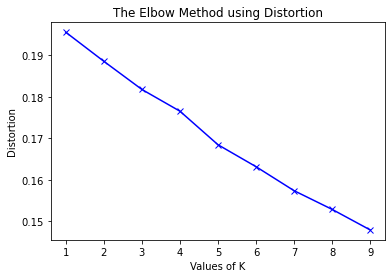

In [399]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(U)
	kmeanModel.fit(U)

	distortions.append(sum(np.min(cdist(U, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / U.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(U, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / U.shape[0]
	mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

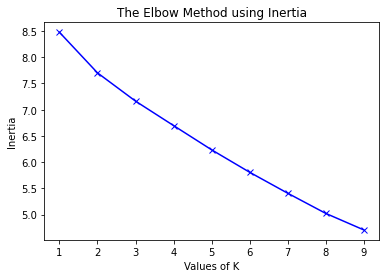

In [400]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [477]:
from collections import defaultdict
dic = defaultdict(list)
for i in range(len(list(H.nodes))):
    dic[km.labels_[i]].append(list(H.nodes)[i])

In [454]:
# import numpy as np
# pos = nx.circular_layout(H)
# r = 7
# radii = list(range(r*1, r*len(dic.keys()) + r, r))

# for ea in pos.keys():
#     new_r = 1
#     for i in range(len(dic.keys())):
#         if(ea in dic[i]):
#             new_r = radii[i]
#     pos[ea] *= new_r

In [483]:
[len(dic[i]) for i in dic.keys()]
dic

defaultdict(list, {1: [1, 2, 5, 7, 9, 10], 0: [3, 4, 6, 8, 11]})

In [479]:
colos = list((np.array(list(nx.get_edge_attributes(H,"Weight").values()) ) > 0).astype(int))

In [480]:
# --- Begin_myhack ---
# All this code should replace original `pos=nx.spring_layout(graph)`
import numpy as np
pos = nx.circular_layout(H)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(dic.keys()))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    posx = 0
    for i in dic.keys():
        if(ea in dic[i]):
            posx = i
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
# --- End_myhack ---

{1: Text(4.5, -8.572527594031472e-16, '1'),
 2: Text(4.341253520348504, 0.5406407669947293, '2'),
 3: Text(-3.084584946649305, 0.909631960151153, '3'),
 4: Text(-3.642314827098238, 0.9898214259758209, '4'),
 5: Text(2.845139338115622, 0.7557496367063056, '5'),
 6: Text(-4.459492965507294, 0.2817326165188505, '6'),
 7: Text(2.5405070344927063, -0.2817325569142066, '7'),
 8: Text(-4.1548607214890225, -0.7557495771016617, '8'),
 9: Text(3.357684994087829, -0.9898214259758213, '9'),
 10: Text(3.915415112955339, -0.9096319601511534, '10'),
 11: Text(-2.65874653925614, -0.5406408862040183, '11')}

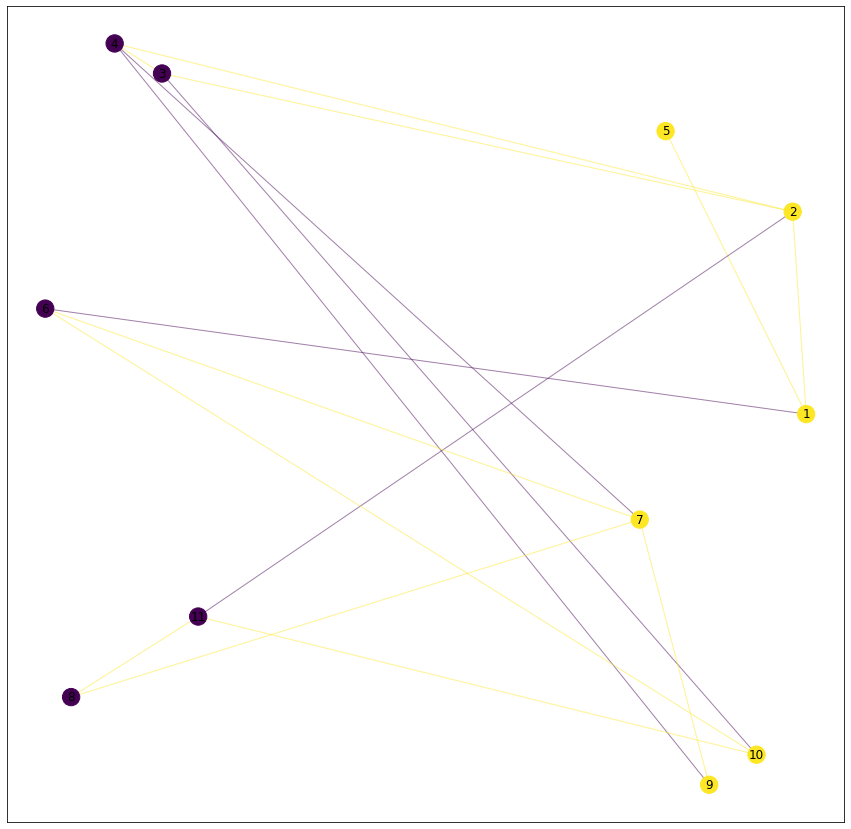

In [487]:
plt.figure(figsize = (15,15))
# plt.xlim(-(r*len(dic.keys()) + r),r*len(dic.keys()) + r + 10)
# plt.ylim(-(r*len(dic.keys()) + r),r*len(dic.keys()) + r + 10)
nx.draw_networkx_nodes(H, pos = pos, node_color = list(km.labels_))
nx.draw_networkx_edges(H, pos = pos, width=1.0, alpha=0.5, edge_color = colos)# edge_cmap = plt.cm.RdBu
# nx.draw_networkx_labels(H, labels = dict(zip(list(H.nodes), km.labels_)), pos = pos)
nx.draw_networkx_labels(H, labels = dict(zip(list(H.nodes), list(H.nodes))), pos = pos)

### STRUCTURAL IMBALANCE!

In [368]:
import dimod
WW = nx.get_edge_attributes(H,"Weight")
nx.set_edge_attributes(H, WW, "sign")
sampler = dimod.RandomSampler()
f, c = dnx.structural_imbalance(H, sampler)

In [369]:
dic = defaultdict(list)
for i in list(H.nodes):
    dic[c[i]].append(i)

In [370]:
# --- Begin_myhack ---
# All this code should replace original `pos=nx.spring_layout(graph)`
import numpy as np
pos = nx.circular_layout(H)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(dic.keys()))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    posx = 0
    for i in range(len(dic.keys())):
        if(ea in dic[i]):
            posx = i
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
# --- End_myhack ---

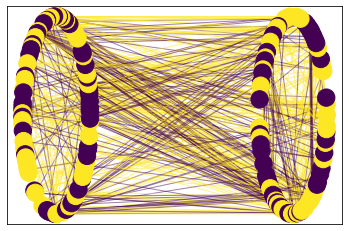

In [371]:
nx.draw_networkx_nodes(H, pos = pos, node_color = list(c.values()))
nx.draw_networkx_edges(H, pos = pos, width=1.0, alpha=0.5, edge_color = colos) # , edge_cmap = plt.cm.RdBu
# nx.draw_networkx_labels(H, labels = dict(zip(list(H.nodes), km.labels_)), pos = pos)